In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


**Get the data as specified by the organizers of the competition**

In [39]:
#Get the data
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Exception: You can only make one environment for this competition.

In [3]:
(market, news) = env.get_training_data()


**Initial Data Analysis**

In [15]:
market.shape, news.shape

((4072956, 20), (9328750, 35))

In [4]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

In [ ]:
# Set time index at market data
#market_train.time = market_train.time.astype('datetime64[D, UTC]')
#news_train.time = news_train.time.astype('datetime64[D, UTC]')

In [16]:
market.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0,-0.02,0.996276,8.486474,8.466474
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0,-0.10,0.997707,31.544074,31.555046
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0,-0.01,0.996124,3.578928,3.665662
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0,-0.43,0.965600,25.359314,25.359137
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0,-0.11,0.997949,40.394522,40.384277


In [17]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072956 entries, 0 to 4072955
Data columns (total 20 columns):
time                        datetime64[ns, UTC]
assetCode                   object
assetName                   category
volume                      float64
close                       float64
open                        float64
returnsClosePrevRaw1        float64
returnsOpenPrevRaw1         float64
returnsClosePrevMktres1     float64
returnsOpenPrevMktres1      float64
returnsClosePrevRaw10       float64
returnsOpenPrevRaw10        float64
returnsClosePrevMktres10    float64
returnsOpenPrevMktres10     float64
returnsOpenNextMktres10     float64
universe                    float64
price_diff                  float64
close_to_open               float64
assetName_mean_open         float64
assetName_mean_close        float64
dtypes: category(1), datetime64[ns, UTC](1), float64(17), object(1)
memory usage: 598.4+ MB


In [18]:
market.describe()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
count,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.056976e+06,4.056968e+06,4.072956e+06,4.072956e+06,3.979946e+06,3.979902e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06
mean,2.665312e+06,3.971225e+01,3.970853e+01,5.473026e-04,9.569113e-03,1.738580e-04,9.309293e-03,5.232021e-03,1.423685e-02,1.638857e-03,1.481702e-02,1.405528e-02,5.949365e-01,3.724335e-03,1.009127e+00,3.971233e+01,3.971241e+01
std,7.687606e+06,4.228810e+01,4.228558e+01,3.697774e-02,7.084388e+00,3.270305e-02,6.968866e+00,8.872484e-02,7.123552e+00,7.517820e-02,7.285742e+00,7.242467e+00,4.909044e-01,1.000417e+00,7.052655e+00,3.440779e+01,3.441273e+01
min,0.000000e+00,7.000000e-02,1.000000e-02,-9.776464e-01,-9.998881e-01,-1.235622e+00,-6.158463e+02,-9.774034e-01,-9.998904e-01,-3.343277e+00,-1.375045e+03,-1.375045e+03,0.000000e+00,-9.824000e+01,5.000505e-03,2.430204e-01,2.432111e-01
25%,4.657968e+05,1.725000e+01,1.725000e+01,-1.089241e-02,-1.108987e-02,-8.569246e-03,-1.002114e-02,-3.339148e-02,-3.337574e-02,-2.927584e-02,-2.962645e-02,-2.970509e-02,0.000000e+00,-2.800000e-01,9.900964e-01,1.987170e+01,1.983533e+01
50%,9.821000e+05,3.030000e+01,3.029000e+01,3.373819e-04,3.824092e-04,-1.236127e-04,-3.356938e-06,5.160339e-03,5.165128e-03,8.329261e-04,1.126206e-03,1.044642e-03,1.000000e+00,0.000000e+00,1.000000e+00,3.300061e+01,3.297748e+01
75%,2.403165e+06,4.986000e+01,4.985000e+01,1.165695e-02,1.183612e-02,8.397528e-03,1.002712e-02,4.297606e-02,4.298507e-02,3.059022e-02,3.171535e-02,3.152750e-02,1.000000e+00,2.900000e-01,1.010146e+00,5.013695e+01,5.015541e+01
max,1.226791e+09,1.578130e+03,1.584440e+03,4.559245e+01,9.209000e+03,4.512244e+01,8.989207e+03,4.667181e+01,9.382000e+03,4.624971e+01,9.761338e+03,9.761338e+03,1.000000e+00,6.018000e+01,9.120000e+03,7.539378e+02,7.536896e+02


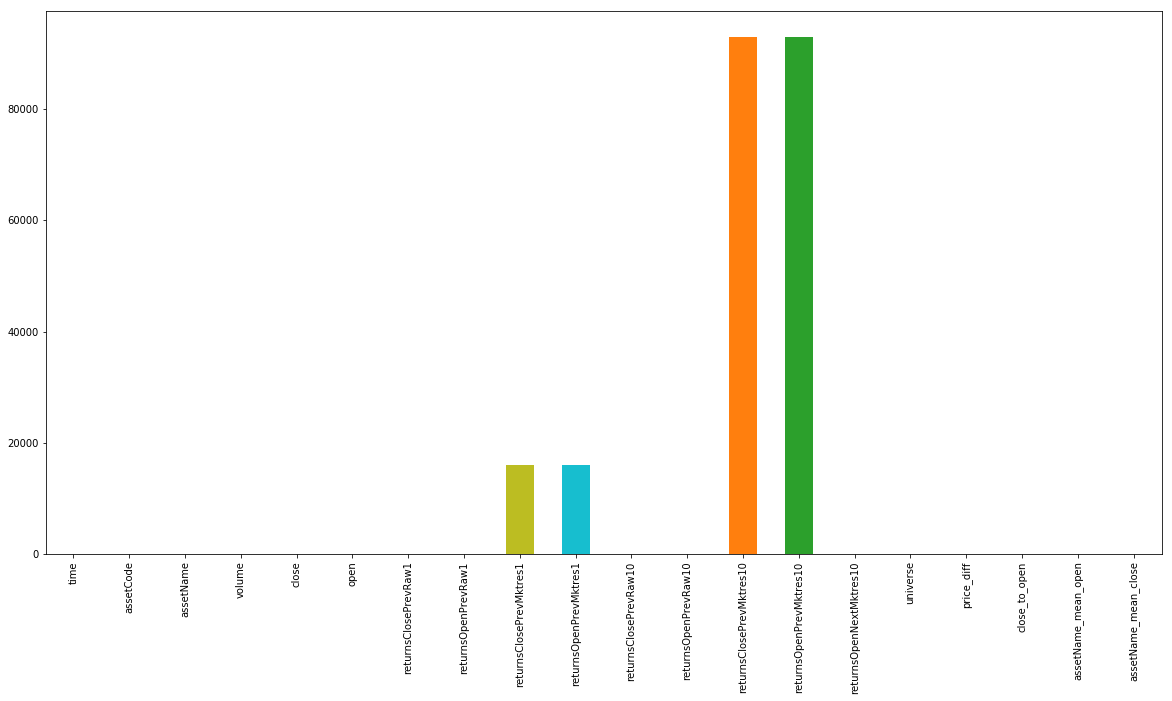

In [19]:
#Check for null values
null_values = market.isna().sum()
plt.figure(figsize=(20,10))
null_values.plot.bar()
plt.show()

Text(0.5,1,'Missing Values')

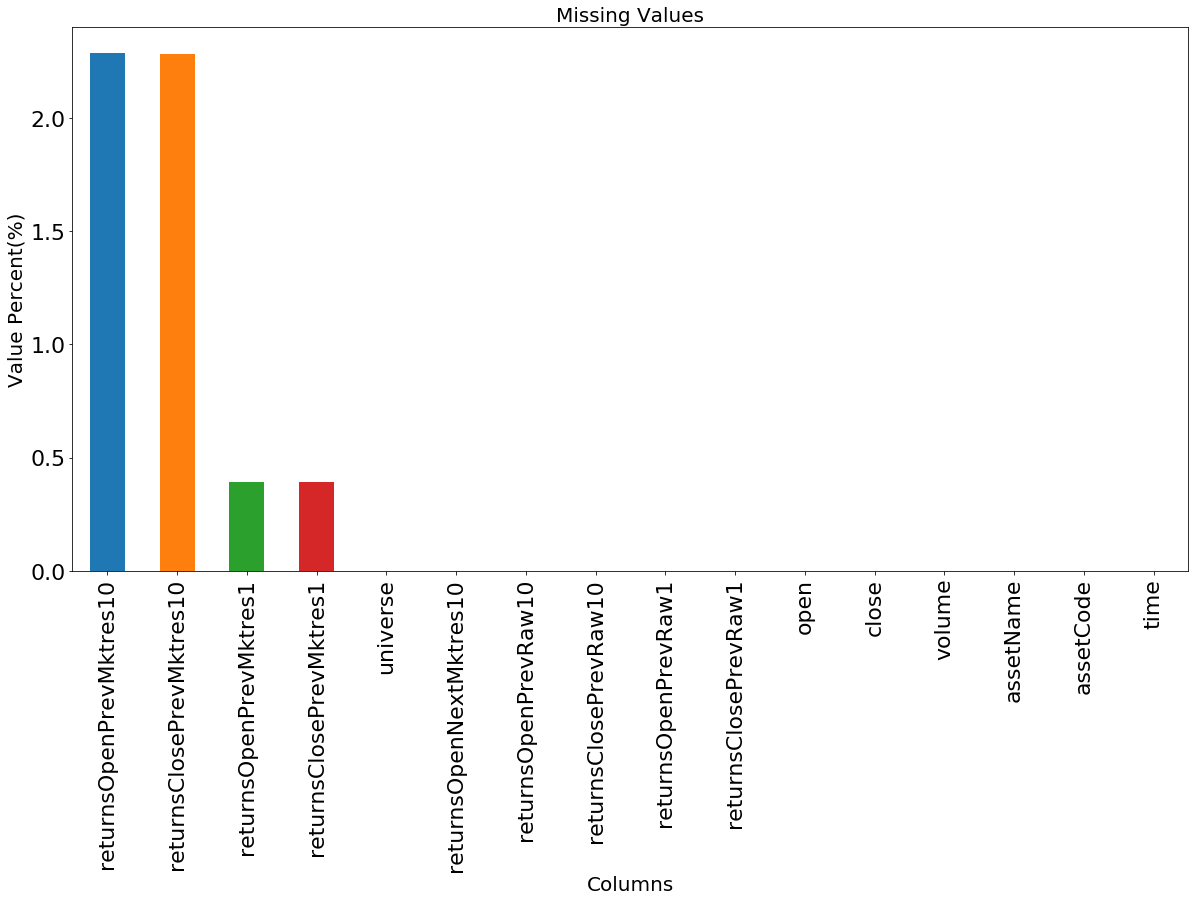

In [5]:
null_values = (100 * market.isnull().sum() / market.shape[0]).sort_values(ascending=False)
null_values.plot(kind="bar", figsize = (20,10), fontsize = 22)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Missing Values", fontsize = 20)

In [6]:
# Count total assets in the market data
number_of_assets=len(market.assetName.unique().categories)
print("Total %d assets" % (number_of_assets))

Total 3511 assets


In [7]:
#Look for outliers
market['price_diff'] = market['close'] - market['open']
market['close_to_open'] =  np.abs(market['close'] / market['open'])
print(f"In {(market['close_to_open'] >= 1.4).sum()} observations price increased by 40% or more.")
print(f"In {(market['close_to_open'] <= 0.6).sum()} observations price decreased by 40% or more.")
print(f"In {(market['close_to_open'] >= 2).sum()} observations price increased by 100% or more.")
print(f"In {(market['close_to_open'] <= 0.5).sum()} observations price decreased by 100% or more.")

In 127 observations price increased by 40% or more.
In 36 observations price decreased by 40% or more.
In 38 observations price increased by 100% or more.
In 16 observations price decreased by 100% or more.


In [8]:
#Further look into outliers
market['price_diff'] = market['close'] - market['open']
grouped = market.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:20]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 20 standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [9]:
#Fix the outliers by replacing the close prices that are too far away from the mean
market['assetName_mean_open'] = market.groupby('assetName')['open'].transform('mean')
market['assetName_mean_close'] = market.groupby('assetName')['close'].transform('mean')

for x, row in market.loc[market['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market.iloc[x,5] = row['assetName_mean_open']
    else:
        market.iloc[x,4] = row['assetName_mean_close']
        
for x, row in market.loc[market['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market.iloc[x,5] = row['assetName_mean_open']
    else:
        market.iloc[x,4] = row['assetName_mean_close']

In [10]:
#Look after fixing
#
market['price_diff'] = market['close'] - market['open']
grouped = market.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:20]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 20 standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

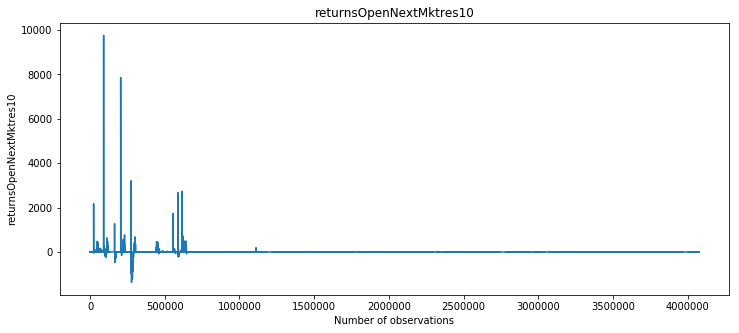

In [22]:
# Plot target column
market.returnsOpenNextMktres10.plot(figsize=(12,5))
plt.title('returnsOpenNextMktres10')
plt.ylabel('returnsOpenNextMktres10')
plt.xlabel('Number of observations')
plt.show()


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



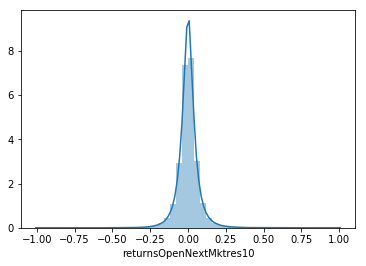

In [14]:
#Show distribution of the target column
sns.distplot(market.returnsOpenNextMktres10.clip(-1,1))
plt.show()

In [ ]:
#Plot volume and price values of an asset
def plotting_asset(market, asset):
   
    #Which asset?
    asset_market = market[market['assetCode'] == asset]
    asset_market.index = asset_market.time

    # Plotting
    f, axis = plt.subplots(2,1, sharex=True, figsize=(12,8))
    # Close price 
    asset_market.close.plot(ax=axis[0], color='darkgreen')
    axis[0].set_ylabel("Price")

    # Volume
    asset_market.volume.plot(ax=axis[1], color='purple')
    axis[1].set_ylabel("Volume")

    # Show the plot
    f.suptitle("Asset %s" % asset, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

plotting_asset(market_train, 'PDCO.O')

In [23]:
news.tail()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
9328745,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,fc80724160cc7bf4,"INTREXON - ON DEC 30, CO, THIRD SECURITY EXECU...",1,1,RTRS,"{'BLR', 'HECA', 'PHMR', 'MRCH', 'US', 'RTRS', ...","{'E', 'U'}",0,1,,False,1,35,{'XON.N'},Intrexon Corp,1,1.0,1,0.115706,0.410445,0.473849,35,0,0,0,0,0,0,1,10,10,10
9328746,2016-12-30 21:56:28+00:00,2016-12-30 21:56:28+00:00,2016-12-30 21:56:06+00:00,2e3e5407e186dd51,INTREXON CORP - AMENDMENT EXTENDS TERM OF SERV...,1,2,RTRS,"{'BLR', 'DBT', 'HECA', 'PHMR', 'MRCH', 'BACT',...","{'E', 'U'}",0,1,,False,1,20,{'XON.N'},Intrexon Corp,1,1.0,1,0.032272,0.122635,0.845093,20,0,0,1,1,1,1,2,11,11,11
9328747,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,cef1bb88f92ca104,EQUITY ALERT: Rosen Law Firm Announces Investi...,3,1,BSW,"{'CMSS', 'CLJ', 'GEN', 'NEWR', 'HECA', 'PHMR',...","{'BSW', 'CNR'}",3734,1,,False,16,664,"{'SGEN.O', 'SGEN.OQ'}",Seattle Genetics Inc,1,1.0,-1,0.651900,0.227707,0.120393,360,0,0,3,4,4,1,2,18,41,41
9328748,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,c26c3df1804571a6,PROFESSIONAL DIVERSITY NETWORK INC - FILES FOR...,1,1,RTRS,"{'BLR', 'SWIT', 'ITSE', 'SISU', 'BACT', 'TMT',...","{'E', 'U'}",0,1,,False,1,23,"{'IPDN.O', 'IPDN.OQ'}",Professional Diversity Network Inc,1,1.0,-1,0.816252,0.126928,0.056819,23,0,0,0,0,0,0,0,3,3,3
9328749,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,daea2d46dc7f5303,"JPMorgan China Region Fund, Inc. Board to Subm...",3,1,BSW,"{'CMSS', 'NEWR', 'INVT', 'BACT', 'BSUP', 'INDS...","{'BSW', 'CNR'}",2969,1,,False,15,492,{'JFC.N'},JPMorgan China Region Fund Inc,1,1.0,1,0.130152,0.388845,0.481002,383,0,0,0,0,0,0,0,0,0,0


In [ ]:
news.info()

In [ ]:
 # Plotting mean values of sentiment analysis.
news[['sentimentNegative', 'sentimentNeutral','sentimentPositive']].mean().plot(kind='bar')
plt.title("Sentiment plot")
plt.show()

In [30]:
#Get a unique label for the asset codes
asset_label = {k: v for v, k in enumerate(market['assetCode'].unique())}

def prep_data(market):
    # Handle asset codes by assigning integer values
    market['assetCodeT'] = market['assetCode'].map(asset_label)
    market_col = ['assetCode','assetCodeT', 'volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 
                        'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 
                        'returnsOpenPrevMktres10']
    #Handle missing values by filling them with zero. We can do this since there are very few. 
    X = market[market_col].fillna(0).values
    if "returnsOpenNextMktres10" in list(market.columns):
        up = (market.returnsOpenNextMktres10 >= 0).values
        r = market.returnsOpenNextMktres10.values
        universe = market.universe
        day = market.time.dt.date
        assert X.shape[0] == up.shape[0] == r.shape[0] == universe.shape[0] == day.shape[0]
    else:
        up = []
        r = []
        universe = []
        day = []
    return X, up, r, universe, day

In [32]:
X, up, r, universe, day = prep_data(market) #prepare the data

In [33]:
from sklearn.model_selection import train_test_split
# r, u and d are used to calculate the scoring metric on test
X_train, X_test, up_train, up_test, _, r_test, _, u_test, _, d_test = \
train_test_split(X, up, r, universe, day, test_size=0.25, random_state=99)

ValueError: Found input variables with inconsistent numbers of samples: [1815, 0, 0, 0, 0]

In [27]:
#Naive model, a benchmark 
#Random predictions according to the Gaussian Distribution between -1 and 1
import random
def random_predictions(template, market, news):
    mu, sigma = 0,0.3
    predict = np.random.normal(mu, 0.3,len(template))
    predict = np.clip(predict,-1,1)
    template.confidenceValue = predict
    
get_days = env.get_prediction_days()



In [28]:
for (market, news, template) in get_days:
    random_predictions(template, market, news)
    env.predict(template)
    
print('Done!')
from sklearn.metrics import accuracy_score
x = accuracy_score(template.confidenceValue, )
env.write_submission_file()   


Done!


KeyError: 'returnsOpenNextMktres10'

In [ ]:
cat_up = CatBoostClassifier(thread_count=4, n_estimators=150, max_depth=8, eta=0.1, loss_function='Logloss' , verbose=10)

cat_X_train = np.delete(X_train,1,1) #get rid of encoded labels since this is duplicate information, CatBoost will handle the assetCodes directly
cat_X_test = np.delete(X_test,1,1)

t = time.time()
print('Fitting Up')
cat_features=[0] #this is just the column(s) in our data set that has categorical data and then we pass it to the model fitting function below
cat_up.fit(cat_X_train, up_train, cat_features) 
print(f'cat Done, time = {time.time() - t}')

In [ ]:
from sklearn.metrics import accuracy_score
catconfidence_test = cat_up.predict_proba(cat_X_test)[:,1]*2 -1

print(accuracy_score(catconfidence_test>0,up_test))
plt.hist(catconfidence_test, bins='auto')
plt.title("CatBoost predicted confidence")
plt.show()

In [ ]:
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_icat = catconfidence_test * r_test * u_test
data2 = {'day' : d_test, 'x_t_icat' : x_t_icat}
df2 = pd.DataFrame(data2)
x_tcat = df2.groupby('day').sum().values.flatten()
mean = np.mean(x_tcat)
std = np.std(x_tcat)
score_testcat = mean / std
print(f'CatBoost score: {score_testcat}')


In [ ]:
days = env.get_prediction_days()

In [ ]:
market_col = ['assetCodeT', 'volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 
                        'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 
                        'returnsOpenPrevMktres10']
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(range(len(cat_up.get_feature_importance(prettified=False))), cat_up.get_feature_importance(prettified=False))
plt.title("Cat Feature Importance")
plt.xticks(range(len(cat_up.get_feature_importance(prettified=False))), market_col, rotation='vertical');


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [35]:
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [34]:
market['price_diff'] = market['close'] - market['open']
market['close/open'] = market['close'] / market['open']
market['assetCode_mean_open'] = market.groupby('assetCode')['open'].transform('mean')
market['assetCode_mean_close'] = market.groupby('assetCode')['close'].transform('mean')

# replace abnormal data record

for i, row in market.loc[market['close/open'] >= 1.5].iterrows():
    if np.abs(row['assetCode_mean_open'] - row['open']) > np.abs(row['assetCode_mean_close'] - row['close']):
        market.iloc[i,5] = row['assetCode_mean_open']
    else:
        market.iloc[i,4] = row['assetCode_mean_close']
    

for i, row in market.loc[market['close/open'] <= 0.5].iterrows():
    if np.abs(row['assetCode_mean_open'] - row['open']) > np.abs(row['assetCode_mean_close'] - row['close']):
        market.iloc[i,5] = row['assetCode_mean_open']
    else:
        market.iloc[i,4] = row['assetCode_mean_close']
        

fill_cols = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10','returnsOpenPrevMktres10']
              
market = market.sort_values(by = ['assetCode','time'], ascending=[True, True])
        

for i in market[fill_cols]:
    market[i] =market[i].fillna(method = 'ffill')

for i in market[fill_cols]:
    market[i] = market[i].fillna(market[i].mean())


market = market.drop(['price_diff','close/open','assetCode_mean_open','assetCode_mean_close'], axis = 1)

#market.info()

### working on news data

news_simplified = news.drop(['sourceTimestamp','provider', 'sourceId', 'headline','takeSequence','subjects', 'audiences',
       'bodySize', 'companyCount', 'headlineTag', 'marketCommentary','sentenceCount', 'wordCount',
       'firstMentionSentence','sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'], axis = 1)

def data_prep(market_df, news_df):
    market_df['time'] = market_df.time.dt.date
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodeLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    market_df = pd.merge(market_df, news_df, how='left', left_on=['time','assetCode'], right_on=['firstCreated', 'assetCodes'])
    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    market_df = market_df.dropna(axis=0)

    return market_df
    
combined = data_prep(market, news_simplified)
#combined.isna().sum()


#combined.info()

kcols = [c for c in combined.columns if c not in['assetCode', 'assetCodes', 'assetCodesLen', 'assetName_x','assetName_y', 'assetCodeT','firstCreated','time_x','time_y','universe','assetCodeLen']]

X = combined[kcols]




In [37]:
y = X['returnsOpenNextMktres10']

KeyError: 'returnsOpenNextMktres10'

In [ ]:

X = X.drop(['returnsOpenNextMktres10'], axis=1)
X

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=100,
                                                    stratify=y)

print('All:', np.bincount(y) / float(len(y)) * 100.0)
print('Training:', np.bincount(train_y) / float(len(train_y)) * 100.0)
print('Validation:', np.bincount(val_y) / float(len(val_y)) * 100.0)

In [ ]:
def join_market_news(market_train_df, news_train_df):
    # Fix asset codes (str -> list)
    news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )

    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Create expandaded news (will repeat every assetCodes' row)
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

    # Free memory
    del news_train_df, df_assetCodes

    # Aggregate numerical news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    
    # Free memory
    del news_train_df_expanded

    # Convert to float32 to save memory
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flat columns
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join with train
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])

    # Free memory
    del news_train_df_aggregated
    
    return market_train_df

In [ ]:
def get_xy(market, news, le=None):
    x, le = get_x(market, news)
    y = market['returnsOpenNextMktres10'].clip(-1, 1)
    return x, y, le


def label_encode(series, min_count):
    vc = series.value_counts()
    le = {c:i for i, c in enumerate(vc.index[vc >= min_count])}
    return le


def get_x(market, news, le=None):
    news['time'] = (news['time'] - np.timedelta64(22,'h')).dt.ceil('1D')

    # Round time of market to 0h of curret day
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join market and news
    x = join_market_news(market, news)
    
    # If not label-encoder... encode assetCode
    if le is None:
        le_assetCode = label_encode(x['assetCode'], min_count=10)
        le_assetName = label_encode(x['assetName'], min_count=5)
    else:
        # 'unpack' label encoders
        le_assetCode, le_assetName = le
        
    x['assetCode'] = x['assetCode'].map(le_assetCode).fillna(-1).astype(int)
    x['assetName'] = x['assetName'].map(le_assetName).fillna(-1).astype(int)
    
    try:
        x.drop(columns=['returnsOpenNextMktres10'], inplace=True)
    except:
        pass
    try:
        x.drop(columns=['universe'], inplace=True)
    except:
        pass
    x['dayofweek'], x['month'] = x.time.dt.dayofweek, x.time.dt.month
    x.drop(columns='time', inplace=True)

    # Fix some mixed-type columns
    for bogus_col in ['marketCommentary_min', 'marketCommentary_max']:
        x[bogus_col] = x[bogus_col].astype(float)
    
    return x, (le_assetCode, le_assetName)

In [ ]:
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [ ]:
#Reduce the memory intake a little bit
    market = market.tail(3_000_000)
    news = news.tail(6_000_000)

In [ ]:
%%time

# This will take some time...
X, y, le = get_xy(market, news)

In [ ]:
X.shape, y.shape

In [ ]:
# Save universe data for latter use
universe = market_train['universe']
time = market_train['time']

# Free memory
del market_train, news_train

In [ ]:
X_ = X

In [ ]:
# Keep only text columns
X = X_#.iloc[:, X.columns.get_loc('urgency_min'):X.columns.get_loc('dayofweek')]

In [ ]:
X.tail()

In [ ]:
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:], y.iloc[n_train:]

In [ ]:
# For valid data, keep only those with universe > 0. This will help calculate the metric
u_valid = (universe.iloc[n_train:] > 0)
t_valid = time.iloc[n_train:]

X_valid = X_valid[u_valid]
y_valid = y_valid[u_valid]
t_valid = t_valid[u_valid]
del u_valid

In [ ]:
# Creat lgb datasets
train_cols = X.columns.tolist()
categorical_cols = [] # ['assetCode', 'assetName', 'dayofweek', 'month']

# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

In [ ]:
# We will 'inject' an extra parameter in order to have access to df_valid['time'] inside sigma_score without globals
dvalid.params = {
    'extra_time': t_valid.factorize()[0]
}

In [ ]:
lgb_params = dict(
    objective = 'regression_l1',
    learning_rate = 0.1,
    num_leaves = 150,
    max_depth = -1,
#     min_data_in_leaf = 1000,
#     min_sum_hessian_in_leaf = 10,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
    metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
    seed = 49 # Change for better luck! :)
)
def sigma_score(preds, valid_data):
    df_time = valid_data.params['extra_time']
    labels = valid_data.get_label()
    
#    assert len(labels) == len(df_time)

    x_t = preds * labels #  * df_valid['universe'] -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True

evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, feval=sigma_score, evals_result=evals_result)


df_result = pd.DataFrame(evals_result['valid'])